In [1]:
pip install dascore 

Note: you may need to restart the kernel to use updated packages.


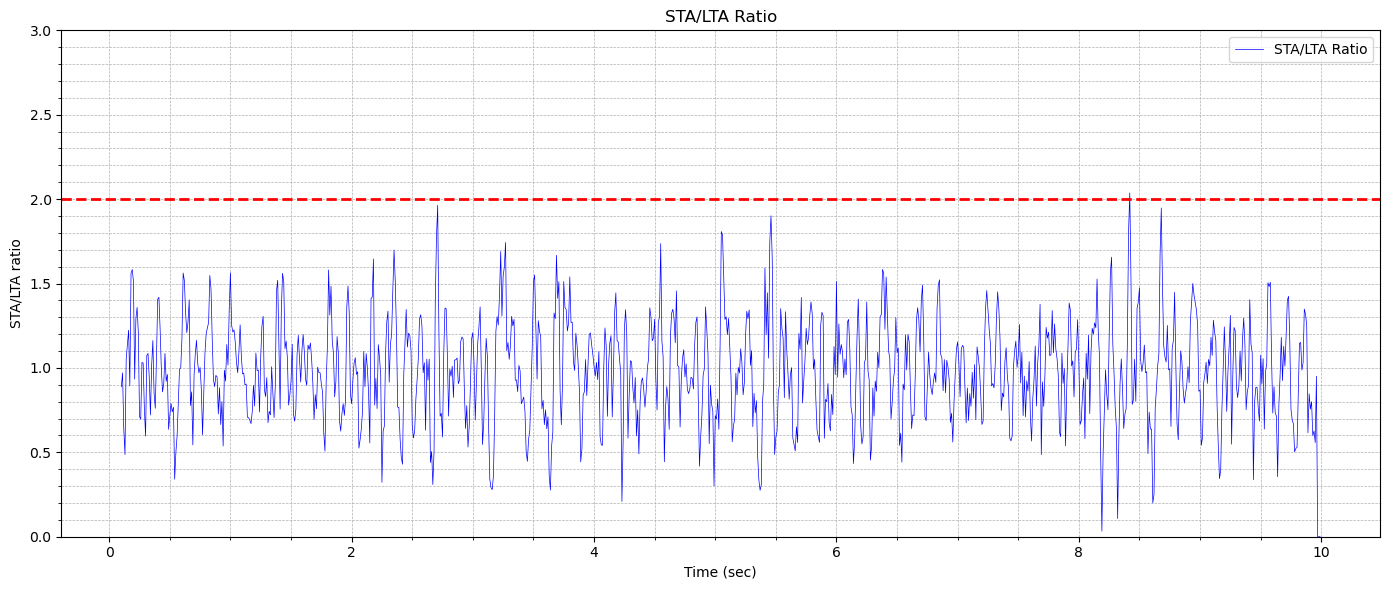

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold): 
    ltawindowlength = int(ltawindowduration * samplingrate) #convert the window durations from seconds to samples 
    stawindowlength = int(stawindowduration * samplingrate) 
    stepsizesamples = int(stepsizeduration * samplingrate)
    n = np.std(timeseries)  # Calculate n dynamically based on the standard deviation of the timeseries

    # arrays to store STA, LTA, and ratio values
    stavalues = np.empty(len(timeseries) - ltawindowlength) 
    ltavalues = np.empty(len(timeseries) - ltawindowlength) 
    ratio = np.zeros(len(timeseries) - ltawindowlength)  # np.zeros = array of a specific type, all entries are zero here. 

    # Compute STA and LTA values and the ratio
    for i in range(ltawindowlength, len(timeseries) - stawindowlength, stepsizesamples):  # Range: ltawindowlength to ensure enough data for LTA
        stastart = i  # Define the start and end points of the STA/LTA windows 
        staend = i + stawindowlength 
        ltastart = i - ltawindowlength 
        ltaend = i 
        #loop through the time series to calculate STA/LTA and define window start and end points 
        stavalues[i - ltawindowlength] = np.mean(np.abs(timeseries[stastart:staend]))  # Absolute values of the signal in short-term window
        ltavalues[i - ltawindowlength] = np.mean(np.abs(timeseries[ltastart:ltaend]))  # Absolute values of the signal in long-term window

        sta = stavalues[i - ltawindowlength]
        lta = ltavalues[i - ltawindowlength]

        # Calculate the STA/LTA ratio using the provided formula by Dr. Martin
        if lta != 0 and sta != 0:
            ratio[i - ltawindowlength] = ((1 / lta) * (n * 2 + (lta - n) * 1)) / ((1 / sta) * (n * 2 + (sta - n) * 1))
        else:
            ratio[i - ltawindowlength] = 0

    # Event detection based on STA/LTA ratio, if either STA/LTA is zero, th ratio is zero 
    events = []
    min_event_duration_samples = int(0.05 * samplingrate)  # Minimum event duration (50 ms)
    min_event_separation_samples = int(0.5 * samplingrate)  # Minimum event separation (0.5 s)
    event_active = False
    event_start = None
    #loop thrhough the ratios to detect events based on the threshold and if the ratio is higher than the threshold, start an event. End the event if the ratio falls below the threshold and check duration/separation criteria before storing events 
    for i in range(len(ratio)):
        if ratio[i] > detection_threshold:
            if not event_active:
                event_start = i
                event_active = True
        else:
            if event_active:
                event_end = i
                event_active = False
                if event_end - event_start >= min_event_duration_samples:
                    if len(events) == 0 or event_start - events[-1][1] >= min_event_separation_samples:
                        events.append((event_start, event_end))

    return stavalues, ltavalues, ratio, events

# Define parameters from the paper 
samplingrate = 100.0  # Hz
stawindowduration = 0.03  #30 ms (120 samples) 
ltawindowduration = 0.1  # 100ms (400 samples) 
stepsizeduration = 0.01  # in seconds (10 ms)
detection_threshold = 2.00  # STA/LTA detection threshold



#synthetic seismic data through time series 
np.random.seed(0)
timeseries = np.random.randn(1000)  

# Apply STA/LTA method
sta, lta, staltaratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

# Define time array for plotting
ltawindowlength = int(ltawindowduration * samplingrate)  # Redefine here for usage
stepsizesamples = int(stepsizeduration * samplingrate)   # Redefine here for usage
time = np.arange(len(timeseries)) / samplingrate
time_stalta = time[ltawindowlength:ltawindowlength + len(sta) * stepsizesamples:stepsizesamples]

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot STA/LTA ratio
plt.plot(time_stalta, staltaratio, label='STA/LTA Ratio', color='blue', linewidth=0.5)
plt.axhline(y=detection_threshold, color='red', linestyle='--', linewidth=2)  # Add detection threshold line
plt.title('STA/LTA Ratio')
plt.xlabel('Time (sec)')
plt.ylabel('STA/LTA ratio')
plt.ylim(0, 3)  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()

# Mark detected events
for event in events:
    plt.axvspan(time_stalta[event[0]], time_stalta[event[1]], color='green', alpha=0.3)

plt.tight_layout()
plt.show()
